# Paddy competition!

## Import libaries and set path

In [1]:
from fastai.vision.all import *
import timm

In [2]:
path = Path()

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#31) [Path('subm_res18_45ep_tta.csv'),Path('README.md'),Path('subm_res18_15ep_tta.csv'),Path('subm_res18_10ep_tta.csv'),Path('sample_submission.csv'),Path('subm_res18_40ep_tta.csv'),Path('subm_res18_35ep_tta.csv'),Path('subm_res18_5ep_tta.csv'),Path('LICENSE'),Path('subm_res18_20ep_tta.csv')...]

In [5]:
trn_path = path/'train_images'

In [6]:
files = get_image_files(trn_path)

## How to check sizes of images slow vs. fast

In [7]:
img = PILImage.create(files[0])

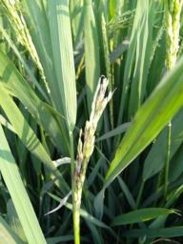

In [8]:
img.to_thumb(244)

In [9]:
img.size

(192, 256)

In [15]:
# a slow way to check all the sizes
%time sizes = [PILImage.create(o).size for o in files]

CPU times: user 33.4 s, sys: 745 ms, total: 34.1 s
Wall time: 58.5 s


In [11]:
from fastcore.parallel import *

In [12]:
def f(o): return PILImage.create(o).size

Using parallel may give us a faster result.

In [14]:
# a faster way to check all the sizes
%time sizes = parallel(f, files, n_workers=2)

CPU times: user 3.39 s, sys: 494 ms, total: 3.88 s
Wall time: 1min 19s


In [20]:
# a faster way to check all the sizes
%time sizes = parallel(f, files, n_workers=4)

CPU times: user 4.72 s, sys: 708 ms, total: 5.43 s
Wall time: 1min 57s


In [21]:
%time sizes = parallel(f, files, n_workers=8)

CPU times: user 4.54 s, sys: 839 ms, total: 5.38 s
Wall time: 2min 1s


Well, more workers added more time for some reason..

## Create a dataloaders

In [6]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=Resize(224))

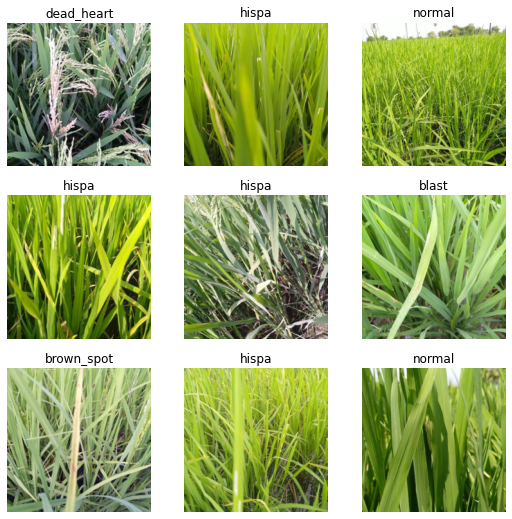

In [7]:
dls.show_batch()

In [8]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [16]:
%time learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


CPU times: user 1.58 s, sys: 781 ms, total: 2.36 s
Wall time: 10.8 s


In [10]:
learn.fine_tune?

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Docstring: Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR.
File:      /usr/local/lib/python3.9/dist-packages/fastai/callback/schedule.py
Type:      method


In [ ]:
learn.lr_find()

/usr/local/lib/python3.9/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.9/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


## Test loaders

In [9]:
doc(dls.test_dl)

In [10]:
test_files = get_image_files(path/'test_images')

In [ ]:
# test_files' order is random
test_files.sort()[-10:]

In [13]:
test_dl = dls.test_dl(test_files)

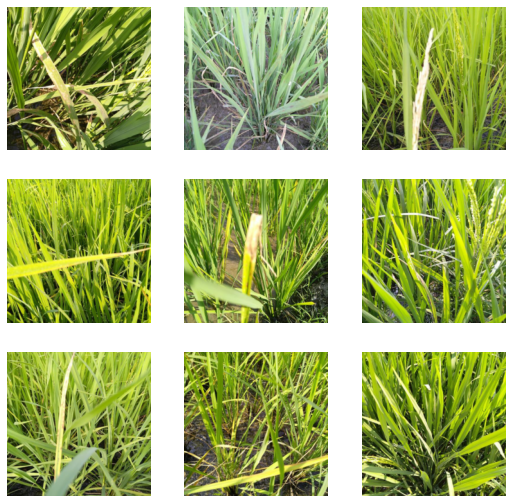

In [14]:
test_dl.show_batch()

In [20]:
preds = learn.get_preds(dl=tst_dl, with_decoded=True)

/usr/local/lib/python3.9/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.9/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


KeyboardInterrupt: 

In [26]:
doc(learn.get_preds)

In [ ]:
probs,_,idx = preds

In [21]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [23]:
mapping = {k:v for k,v in enumerate(dls.vocab)}
mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [ ]:
results = idxs.map(mapping)

In [ ]:
# disregard this
idxs = pd.Series(idxs.numpy(), names="idxs")

In [ ]:
# also disregard
idxs.map(list(dls.vocab))

In [17]:
doc(learn.get_preds)

In [19]:
ss = pd.read_csv('sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [ ]:
ss[label] = results

In [ ]:
ss.to_csv('subm.csv', index=False)

In [ ]:
!head subm.csv

In [25]:
learn.show_results()

KeyboardInterrupt: 